# Climb Dataset
<a href = https://www.kaggle.com/datasets/jordizar/climb-dataset> Original Link </a>

## Motivation & Problem Formulation
We intend to to predict the maximum grade achieved by climbers based on various variables provided in the dataset by training various regression models.

## Table of Contents
* [Importing Dataset](#importing-dataset)
* [Exploratory Analysis & Data Cleaning](#exploratory-analysis-and-data-cleaning)
* [Machine Learning](#machine-learning)
* [Conclusions](#conclusions)
* [Considerations](#considerations)

In [1]:
#Import libs

import numpy as np
import pandas as pd
import seaborn as sb
import sys
import matplotlib.pyplot as plt # data visualization
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
%%script false --no-raise-error

# Cell for Colaboratory init
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

climber_id = "1pwhxhHNFi8cueSq9C3TkzC0yJ_AqeqEz"
grades_id  = "1pZoq43V79U6GFUcNqp5cJyr0LtxQ0M3o"

downloaded = drive.CreateFile({'id':climber_id}) 
downloaded.GetContentFile('climber_df.csv')
downloaded = drive.CreateFile({'id':grades_id}) 
downloaded.GetContentFile('grades_conversion_table.csv')  

## Importing Dataset <a class="anchor" id="importing-dataset"></a>
First, we import the necessary files

**climber_df.csv** - Raw data of the climbers  
**grades_conversion_table.csv** - Lookup table for climbing grades

In [3]:
# Import data
climber_df = pd.read_csv("climber_df.csv")
grades_raw = pd.read_csv("grades_conversion_table.csv")

# Create clean dataset, and track the cleaning status
dataset_raw = climber_df.copy()
status = set()

# Data Cleaning and Exploratory Analysis<a class="anchor" id="exploratory-analysis-and-data-cleaning"></a>
In this section, we analyse and clean the following variables:
* [Country](#country)
* [Height, Weight, Age](#height-weight-age)
* [Erronous Data](#errors)
* [Years Climbed](#years-climbed)
* Grades

Lastly, we create a [correlation heatmap](#corr-map) to summarise our changes after data cleaning, and identify variables to train our model with.

# Initial look at the Dataset

Taking a look at the dataset, we noticed some variables have erronous data present.

For example, in certain rows of data, a climber's date of first ascend comes after their date of last ascend. The same goes for year of first ascend and year of last ascend. This could be due to an error when inputting data where the data was flipped between the 2 variables.

We will proceed to clean the erronous data and remove these erronous entries.

In [4]:
# Display basic info

# Display the first table
print("Dataset_Raw")
display(dataset_raw);
dataset_raw.info();

# Print a separator
print('\n')

# Display the second table
display(grades_raw);
grades_raw.info();

#Making a new dataset to keep track of cleaned dataset
dataset_cleaned = dataset_raw.copy()

Dataset_Raw


user_id country  sex  height  weight   age  years_cl  \
0            1     SWE    0     177      73  41.0        21   
1            3     SWE    0     180      78  44.0        22   
2            4     SWE    1     165      58  33.0        16   
3           10     SWE    0     167      63  52.0        25   
4           16     NOR    0     177      68  44.0        21   
...        ...     ...  ...     ...     ...   ...       ...   
10922    66987     ESP    0     194      83  33.0         5   
10923    66988     USA    0     183      78  22.0         1   
10924    67009   other    0     165      63  41.0        20   
10925    67019     NOR    0     172      73  26.0         4   
10926    67020     DEU    0     178      78  24.0        12   

                date_first            date_last  grades_count  grades_first  \
0      1999-02-06 23:00:00  2001-07-31 22:00:00            84            36   
1      1999-03-31 22:00:00  2000-07-19 22:00:00            12            53   
2      2004-06-30 22:00:00  2009-05-26 22:00:00           119            53   
3      2000-01-14 23:00:00  2017-06-01 22:00:00           298            53   
4      1998-02-27 23:00:00  2010-05-13 22:00:00             5            53   
...                    ...                  ...           ...           ...   
10922  2015-05-01 22:00:00  2017-09-03 22:00:00            27            35   
10923  2017-09-03 22:00:00  2017-09-06 22:00:00             2            33   
10924  2017-09-09 22:00:00  2003-06-19 22:00:00            35            53   
10925  2017-06-14 22:00:00  2017-08-11 22:00:00             7            44   
10926  2017-03-03 23:00:00  2017-07-14 22:00:00            10            33   

       grades_last  grades_max  grades_mean  year_first  year_last  
0               55          62    46.750000        1999       2001  
1               51          59    52.833333        1999       2000  
2               49          64    53.890756        2004       2009  
3               49          63    49.406040        2000       2017  
4               49          53    51.400000        1998       2010  
...            ...         ...          ...         ...        ...  
10922           44          49    39.666667        2015       2017  
10923           28          33    30.500000        2017       2017  
10924           46          59    45.800000        2017       2003  
10925           46          46    42.714286        2017       2017  
10926           36          55    41.500000        2017       2017  

[10927 rows x 16 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10927 entries, 0 to 10926
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10927 non-null  int64  
 1   country       10927 non-null  object 
 2   sex           10927 non-null  int64  
 3   height        10927 non-null  int64  
 4   weight        10927 non-null  int64  
 5   age           10927 non-null  float64
 6   years_cl      10927 non-null  int64  
 7   date_first    10927 non-null  object 
 8   date_last     10927 non-null  object 
 9   grades_count  10927 non-null  int64  
 10  grades_first  10927 non-null  int64  
 11  grades_last   10927 non-null  int64  
 12  grades_max    10927 non-null  int64  
 13  grades_mean   10927 non-null  float64
 14  year_first    10927 non-null  int64  
 15  year_last     10927 non-null  int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 1.3+ MB




Unnamed: 0  grade_id grade_fra
0            0         0         -
1            1         1         -
2            2         2         -
3            3         3         1
4            4         4        1a
..         ...       ...       ...
80          80        80    9b+/9c
81          81        81        9c
82          82        82      9c/+
83          83        83       9c+
84          84        84   9c+/10a

[85 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  85 non-null     int64 
 1   grade_id    85 non-null     int64 
 2   grade_fra   85 non-null     object
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


After Data Cleaning, we generate a heatmap on the dataset to see the correlation between variables and possibly determine which variables are valuable to be used in the later steps when we train the model.

A preliminary check shows a few expected correlations:

1. Gender is inversely correlated with height and weight. This could be due to females being generally shorter and lighter than males.

2. Age and Years Climbed (years_cl) are directly correlated. This is likely due to the fact that the longer someone has spent climbing, they are also likely to be older.


<Axes: >

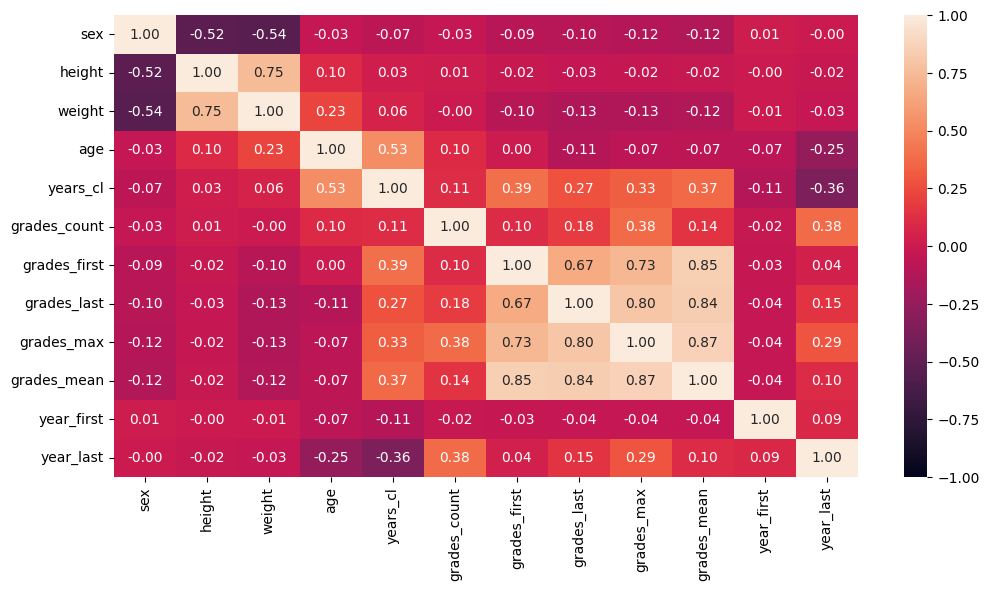

In [5]:
dataset_cleaned_corr = pd.DataFrame(dataset_cleaned[["sex", "height", "weight", "age", "years_cl", "grades_count", "grades_first", "grades_last", "grades_max", "grades_mean", "year_first", "year_last"]])

fig, ax = plt.subplots(figsize=(12,6)) 
sb.heatmap(dataset_cleaned_corr.corr(), vmin = -1, vmax = 1, annot=True, fmt = ".2f")

# Grades<a class="anchor" id="grades"></a>

Our Target Variable: grades_max

The grades-related variables: 
1. grades_count
2. grades_first
3. grades_last
4. grades_mean



In [6]:
grades = dataset_cleaned[["grades_max", "grades_first", "grades_last", "grades_mean"]]

## Grades_Max

From a simple data-visualization of our target variable in the dataset, we can see the spread of the maximum grades of the climbers in the dataset.

We can note a few things from the current grades_max in the dataset:
1. The lowest grades_max is grade_id of 29, which is a difficulty of 5 on the Fontainebleau Scale or V1 on the Hueco "V" grade, a.k.a. V-scale.

2. The highest grades_max is a grade_id of 77, which is a 9b on the Fontainebleau Scale.

2. The average grades_max is a grade_id of 56, which is a difficulty of 7b+/7c on the Fontainebleau Scale or a V6 on the V-scale.

In [7]:
grades['grades_max'].describe()

count    10927.000000
mean        53.764437
std          9.679533
min         29.000000
25%         46.000000
50%         55.000000
75%         62.000000
max         77.000000
Name: grades_max, dtype: float64

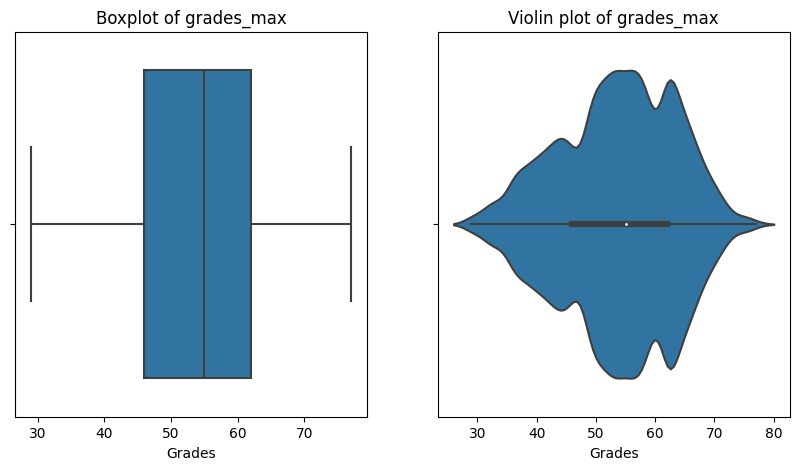

count    10927.000000
mean        53.764437
std          9.679533
min         29.000000
25%         46.000000
50%         55.000000
75%         62.000000
max         77.000000
Name: grades_max, dtype: float64

In [8]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a horizontal boxplot of grades_max
sb.boxplot(x=grades['grades_max'], ax=axs[0], orient='horizontal')
axs[0].set_title('Boxplot of grades_max')
axs[0].set_xlabel('Grades')

# Create a horizontal violin plot of grades_max in the second subplot
sb.violinplot(x=grades['grades_max'], ax=axs[1], orient='h')
axs[1].set_title('Violin plot of grades_max')
axs[1].set_xlabel('Grades')

# Show the plot
plt.show()
grades['grades_max'].describe()

## Country<a class="anchor" id="country"></a>
First, we observe that:
1. Data for this column is categorical and is stored as unordered 3-character strings (eg. ESP, POL)
2. Most data is collected from Europe
3. There is a substantial difference between countries in median, upper and lower quartiles which could be useful

We then conclude that the following steps should be taken
1. Countries should be encoded by integers
2. Their mappings should be ordered based on some indicator (mean, upper quartile, lower quartile, median)

We perform this mapping with different indicators, and select **mean** as the most representative indicator due to its highest correlation.

Number of Countries : 26


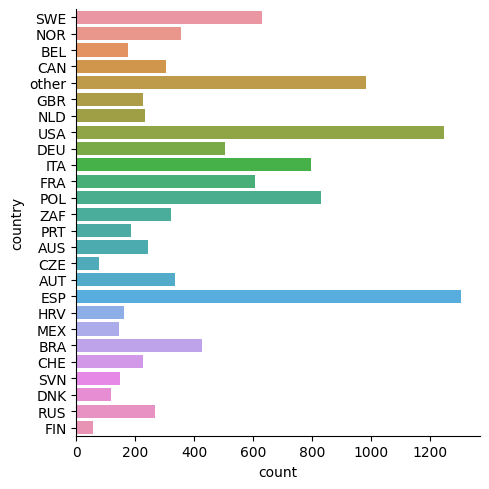

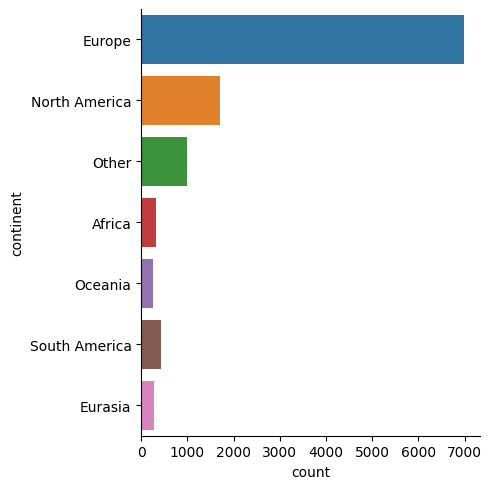

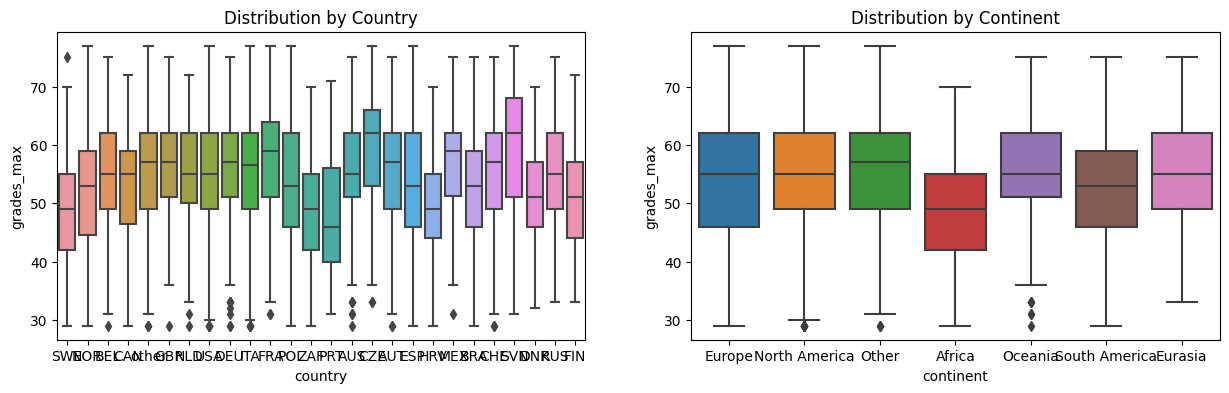

In [9]:
# Data Visualisation and Observations

# Countries in the Dataset
print("Number of Countries :", len(dataset_raw["country"].unique()))

continent_map = dict(
    **{a:"Europe" for a in ['ESP','POL','ITA','SWE','FRA','DEU','NOR','AUT','NLD','GBR',
                            'CHE','PRT', 'BEL', 'HRV', 'SVN', 'DNK', 'CZE', 'FIN']},
    **{a:"North America" for a in ['USA', 'CAN', 'MEX']},
    **{"BRA":"South America","ZAF":"Africa","AUS":"Oceania","RUS":"Eurasia", "other":"Other"}
)
# Grouping countries into continents
continent = dataset_cleaned.copy()
continent["continent"] = continent["country"].map(continent_map)

continent.country.value_counts()
# Climbers in each Continent
sb.catplot(y = "country", data = dataset_cleaned, kind = "count");
sb.catplot(y = "continent", data = continent, kind = "count");

# Compare distributions by country

fig, axis = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
axis[0].set_title("Distribution by Country")
sb.boxplot(x = 'country', y = 'grades_max', data = dataset_cleaned, ax=axis[0]);
axis[1].set_title("Distribution by Continent")
sb.boxplot(x = 'continent', y = 'grades_max', data = continent, ax=axis[1]);

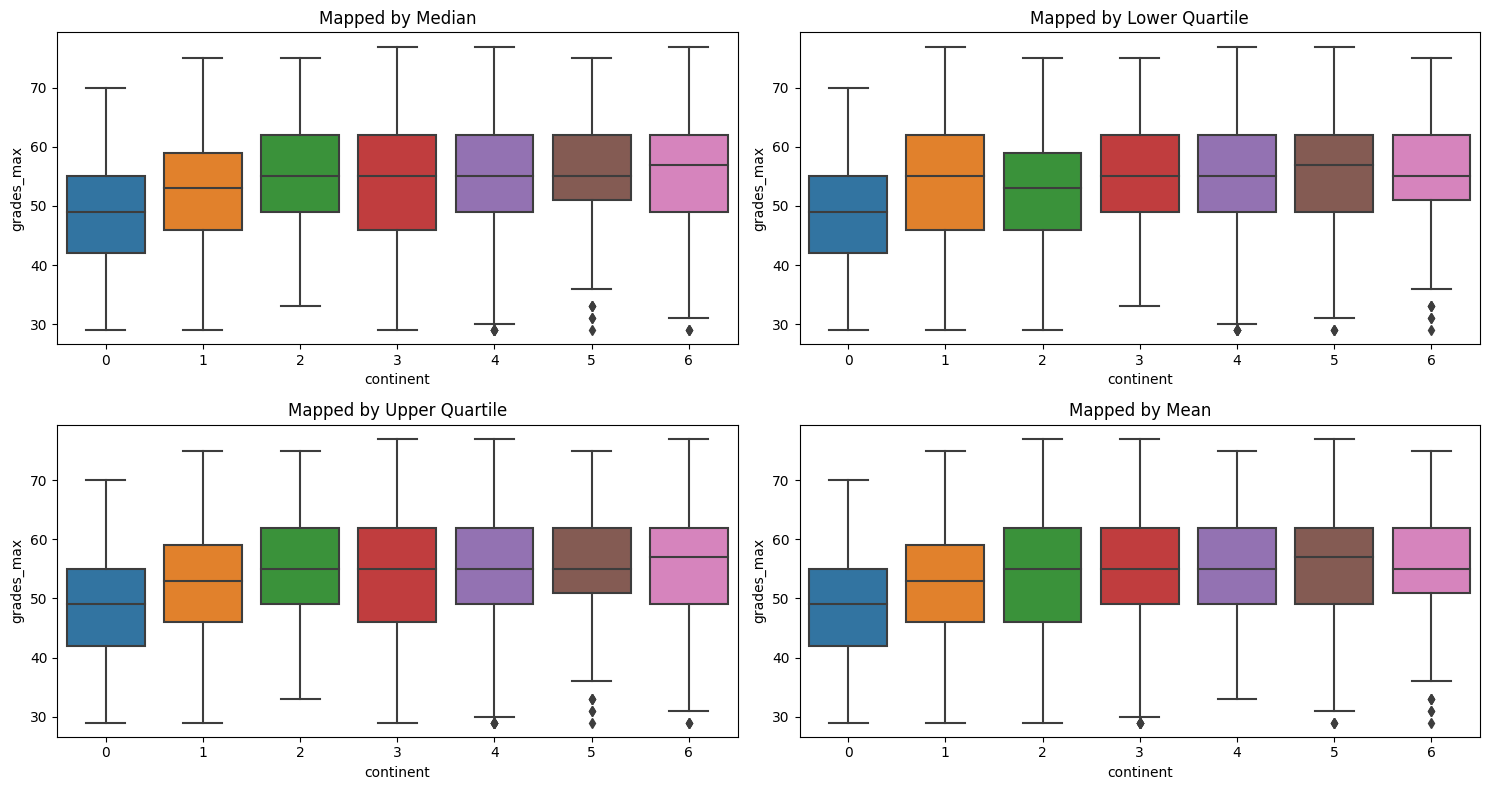

median_map  lower_map  upper_map  mean_map  grades_max
median_map    1.000000   0.759867   1.000000  0.877321    0.090876
lower_map     0.759867   1.000000   0.759867  0.880429    0.062337
upper_map     1.000000   0.759867   1.000000  0.877321    0.090876
mean_map      0.877321   0.880429   0.877321  1.000000    0.085376
grades_max    0.090876   0.062337   0.090876  0.085376    1.000000

Chosen Mapping: Upper Quartile

 {'Africa': 0, 'South America': 1, 'Eurasia': 2, 'Europe': 3, 'North America': 4, 'Oceania': 5, 'Other': 6}

Remapped country column by mean


In [10]:
# Helper function, remaps countries based on the provided indicator
def rank_countries(func):
    order = []
    for x in dataset_raw["country"].unique():
        order.append([func(x), x])
    order.sort()
    mapping = {a[1]:b for b, a in enumerate(order)}

    # Remap country values (if not already mapped)
    remapped = pd.DataFrame({"grades_max": dataset_cleaned["grades_max"],
                             "country": dataset_cleaned["country"].map(mapping)})
    return mapping, remapped

def rank_continents(func):
    order = []
    for x in continent["continent"].unique():
        order.append([func(x), x])
    order.sort()
    mapping = {a[1]:b for b, a in enumerate(order)}

    # Remap country values (if not already mapped)
    remapped = pd.DataFrame({"grades_max": dataset_cleaned["grades_max"],
                             "continent": continent["continent"].map(mapping)})
    return mapping, remapped

med_map, countries_med = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].median())
hi_map, countries_hi = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].quantile(0.75))
lo_map, countries_lo = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].quantile(0.25))
mean_map, countries_mean = rank_continents(lambda x: dataset_cleaned[continent["continent"]==x]["grades_max"].mean())

# Display results
fig, axis = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
axis[0,0].set_title("Mapped by Median")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_med, ax = axis[0,0]);
axis[0,1].set_title("Mapped by Lower Quartile")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_lo, ax = axis[0,1]);
axis[1,0].set_title("Mapped by Upper Quartile")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_hi, ax = axis[1,0]);
axis[1,1].set_title("Mapped by Mean")
sb.boxplot(x = 'continent', y = 'grades_max', data = countries_mean, ax = axis[1,1]);

fig.tight_layout()
plt.show()

# Compare correlation and choose a mapping to use
country_corr = pd.DataFrame({
                "median_map": countries_med["continent"],
                "lower_map": countries_lo["continent"],
                "upper_map": countries_hi["continent"],
                "mean_map": countries_mean["continent"],
                "grades_max": dataset_cleaned["grades_max"],
                })
display(country_corr.corr())
plt.show()
print("Chosen Mapping: Upper Quartile\n\n", hi_map)
if not "country" in status:
    dataset_cleaned["continent"] = countries_hi["continent"]
    status.add("country")

print("\nRemapped country column by mean")

## Height, Weight and Age<a class="anchor" id="height-weight-age"></a>
First, we observe that:
1. Data is scalar and stored as integers for all 3 variables
2. Plotting their distributions give relatively balanced normal distributions:
  * The distribution of weight is slightly odd, but still follows a bell-curve shape. The 'wavelike' shape of its distribution could possibly from rounding errors when reporting the weight of each climber
3. Running a correlation heatmap gives us relatively low correlation to all 3 variables

### Height and Weight
To make these variables more relevant, we can use their values to calculate BMI using the formula:

$BMI = \frac{weight/kg}{[height/m]^2}$

> Note that this formula is **not** a linear combination of the two variables and is hence a useful operation to perform on the variables.

Calculating correlation of BMI with `grades_max`, we see that the correlation has improved from the original height and weight correlation, suggesting that BMI will be a more useful predictor than the raw values of height and weight from the original dataset.

### Age
It is observed that the correlation of `age` is extremely low. Subtracting `years_cl`, from `age` we can obtain the age that they started climbing. However this is not a useful operation as it is a linear combination of the variables used.

Hence, we keep age and leave it to the model to decide its usefulness.


CONCLUSION: Added bmi


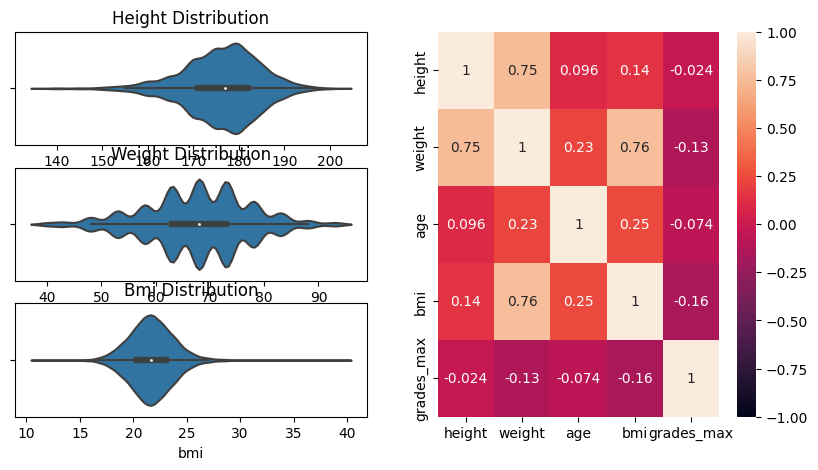

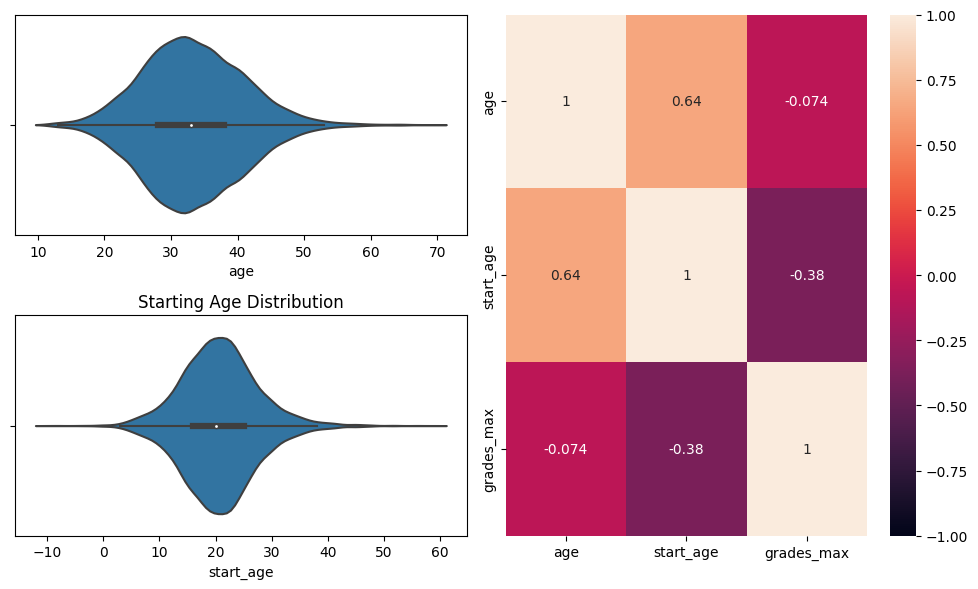

CONCLUSION: Added start_age


In [11]:
fig, axis = plt.subplots(3, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
axis[0,0].set_title("Height Distribution")
sb.violinplot(x = 'height', data = dataset_cleaned, ax = axis[0,0]);
axis[1,0].set_title("Weight Distribution")
sb.violinplot(x = 'weight', data = dataset_cleaned, ax = axis[1,0]);


gs = axis[0, 1].get_gridspec()
for ax in axis[0:, -1]: ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

# Calculate bmi and perform correlation
bmi = pd.DataFrame({
    "height": dataset_cleaned["height"],
    "weight": dataset_cleaned["weight"],
    "age": dataset_cleaned["age"],
    "bmi": dataset_cleaned["weight"]/dataset_cleaned["height"]/dataset_cleaned["height"]*10000,
    "grades_max": dataset_cleaned["grades_max"]
})

axis[2,0].set_title("Bmi Distribution")
sb.violinplot(x = 'bmi', data = bmi, ax = axis[2,0]);

sb.heatmap(bmi.corr(),vmin = -1,vmax = 1, annot=True, ax=axbig)

# Add bmi to dataset_cleaned and drop height/weight 
dataset_cleaned["bmi"] = bmi["bmi"]
print("CONCLUSION: Added bmi")

# Plot distribution of age
fig, axis = plt.subplots(2, 2)
fig.set_figheight(6)
fig.set_figwidth(10)
gs = axis[0, 1].get_gridspec()
for ax in axis[0:, -1]: ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

# Calculate start age and perform correlation
age = pd.DataFrame({
    "age": dataset_cleaned["age"],
    "start_age": dataset_cleaned["age"]-dataset_cleaned["years_cl"],
    "grades_max": dataset_cleaned["grades_max"]
})

axis[1,0].set_title("Age Distribution")
sb.violinplot(x = 'age', data = age, ax = axis[0,0]);
axis[1,0].set_title("Starting Age Distribution")
sb.violinplot(x = 'start_age', data = age, ax = axis[1,0]);

sb.heatmap(age.corr(),vmin = -1,vmax = 1, annot=True, ax=axbig)
fig.tight_layout()
plt.show()

dataset_cleaned["start_age"] = age["start_age"]
print("CONCLUSION: Added start_age")

## Years Climbed<a class="anchor" id="years-climbed"></a>
The dataset provides us with a scalar `years_cl`, described by the dataset author as the number of "years climbing". However, this information is insufficient:
1. "Years climbing" may refer to the number of years spent climbing regulary, or the number of years since the first climb (The climber may no longer be active)
2. We can convert `years_cl` to `days_cl` with the approximation: $days\_climbed = years\_climbed*365$
3. Taking the difference between `date_first` and `date_last` (We name this variable `days_diff`) gives another measure of days spent climbing which has a vastly different distribution from `years_cl`: These variables appear mutually exclusive, but it is unclear which variable might be more useful as a predictor.

To identify which variable we want to use, we perform the following steps:
1. Compare each variables' correlation to `grade_max`
2. We can also obtain the frequency that the climber did climbs while he was active using the formula:  
   $frequency=\frac{grades\_count}{number\_of\_days}$

> Additional Note: It was noticed that `date_first` and `date_last` was sometimes swapped in the dataset, hence we also perform the `abs()` operation on `days_diff` to remove this error

We observe that
* `days_diff` has a far stronger correlation to `grades_max` than `days_cl`
* Both versions of frequency have a lower correlation to `grades_max` than their original variables, hence frequency is not a useful predictor for `grades_max`

As previously mentioned, `days_diff` and `days_cl` are mutually exclusive variables. Hence, we should discard `years_cl` and replace it with `days_diff`. `date_first`, `date_last`, `year_first` and `year_last` can additionally be dropped from the dataset.

grades_count  years_cl  days_cl  days_diff   freq_cl  freq_diff  \
0                84        21     7665        905  0.010959   0.092818   
1                12        22     8030        476  0.001494   0.025210   
2               119        16     5840       1791  0.020377   0.066443   
3               298        25     9125       6347  0.032658   0.046951   
4                 5        21     7665       4457  0.000652   0.001122   
...             ...       ...      ...        ...       ...        ...   
10922            27         5     1825        856  0.014795   0.031542   
10923             2         1      365          3  0.005479   0.666667   
10924            35        20     7300       5196  0.004795   0.006736   
10925             7         4     1460         58  0.004795   0.120690   
10926            10        12     4380        132  0.002283   0.075758   

       grades_max  
0              62  
1              59  
2              64  
3              63  
4              53  
...           ...  
10922          49  
10923          33  
10924          59  
10925          46  
10926          55  

[10927 rows x 7 columns]

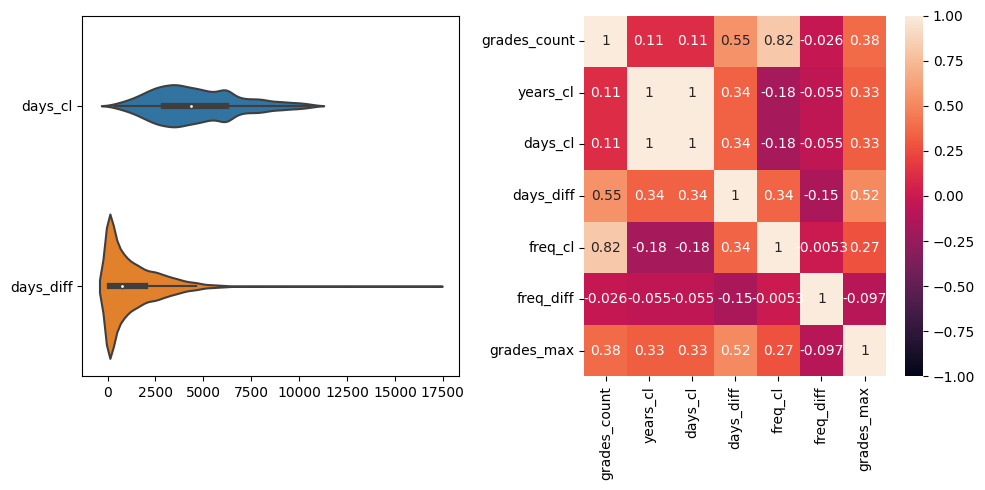

CONCLUSION: days_diff added


In [12]:
from datetime import datetime

fmt = "%Y-%m-%d %H:%M:%S"
duration = pd.DataFrame({
    "grades_count": dataset_cleaned["grades_count"],
    "years_cl": dataset_cleaned["years_cl"],
    "days_cl": dataset_cleaned["years_cl"]*365
})

def get_days_diff(row):
    fmt = "%Y-%m-%d %H:%M:%S"
    date_first = datetime.strptime(row["date_first"], fmt)
    date_last = datetime.strptime(row["date_last"], fmt)
    return abs((date_last - date_first).days)

# Use apply method to calculate the difference in days for all rows
days_diff = dataset_cleaned.apply(get_days_diff, axis=1)

# Add the days_diff column to the duration DataFrame
duration["days_diff"] = days_diff

duration["freq_cl"] = dataset_cleaned["grades_count"]/duration["days_cl"]
duration["freq_diff"] = dataset_cleaned["grades_count"]/duration["days_diff"]
duration["grades_max"] = dataset_cleaned["grades_max"]

display(duration)

fig, axis = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)
sb.violinplot(data = duration[["days_cl", "days_diff"]], orient='h', ax = axis[0]);
sb.heatmap(duration.corr(),vmin = -1,vmax = 1, annot=True)

fig.tight_layout()
plt.show()

#Added days_diff and dropped years_cl, date_first and date_last
dataset_cleaned["days_diff"] = duration["days_diff"]

print("CONCLUSION: days_diff added")

# Outliers

## Outliers Visualization
Taking a look at the variables and identifying the outliers for each variable, we notice a few things:

1. Aside from country and sex, the variables chosen all have outliers.

2. grades_count have the highest amount of outliers.


user_id country  sex  height  weight   age  years_cl  \
268      1522     USA    0     158      93  47.0        24   
2519    13523     USA    0     153      93  33.0        12   
4076    21285     DEU    1     150      88  26.0        15   
6135    30463     USA    1     145      78  31.0        17   

               date_first            date_last  grades_count  grades_first  \
268   2002-04-30 22:00:00  2014-10-17 22:00:00           127            51   
2519  2006-06-14 22:00:00  2006-08-06 22:00:00             2            32   
4076  2008-05-01 22:00:00  2009-09-25 22:00:00            45            62   
6135  2007-06-30 22:00:00  2008-04-24 22:00:00            12            37   

      grades_last  grades_max  grades_mean  year_first  year_last  continent  \
268            46          62    51.724409        2002       2014          4   
2519           38          38    35.000000        2006       2006          4   
4076           59          64    55.955556        2008       2009          3   
6135           39          41    35.416667        2007       2008          4   

            bmi  start_age  days_diff  
268   37.253645       23.0       4553  
2519  39.728310       21.0         53  
4076  39.111111       11.0        512  
6135  37.098692       14.0        299

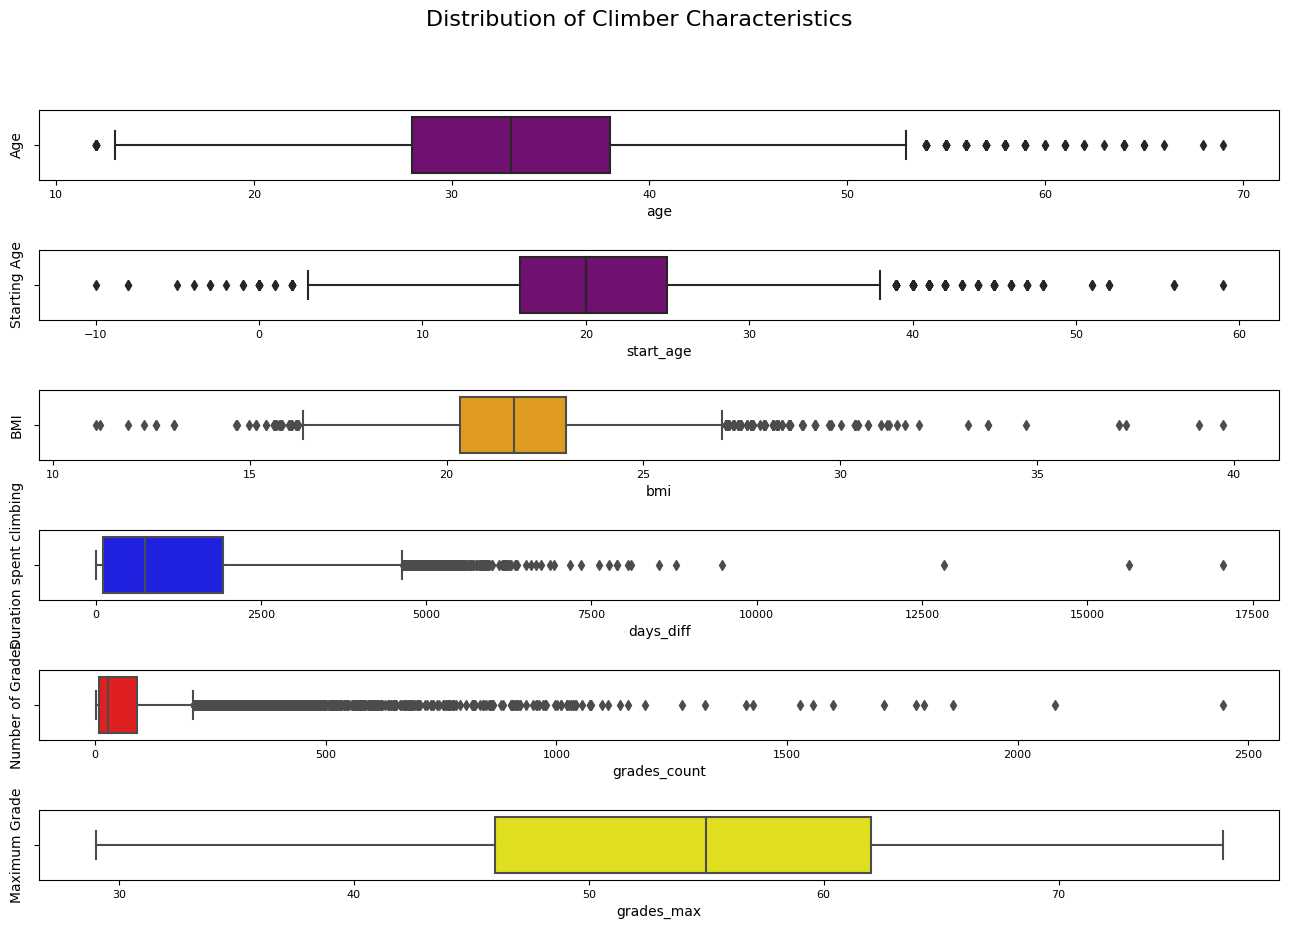

In [13]:
outliers = dataset_cleaned.copy()

f, axes = plt.subplots(6, 1, figsize=(16, 10))

sb.boxplot(x = outliers["age"],orient = "h", ax = axes[0], color="purple")
axes[0].set_ylabel("Age")
axes[0].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["start_age"],orient = "h", ax = axes[1], color="purple")
axes[1].set_ylabel("Starting Age")
axes[1].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["bmi"], orient = "h", ax = axes[2], color="orange")
axes[2].set_ylabel("BMI")
axes[2].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["days_diff"], orient = "h", ax = axes[3], color="blue")
axes[3].set_ylabel("Duration spent climbing")
axes[3].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["grades_count"], orient = "h", ax = axes[4], color="red")
axes[4].set_ylabel("Number of Grades")
axes[4].tick_params(axis='x', labelsize=8)

sb.boxplot(x = outliers["grades_max"], orient = "h", ax = axes[5], color="yellow")
axes[5].set_ylabel("Maximum Grade")
axes[5].tick_params(axis='x', labelsize=8)

plt.subplots_adjust(hspace=1)
plt.suptitle("Distribution of Climber Characteristics", fontsize=16);

display(outliers[outliers["bmi"]>35])

## Outlier Removal



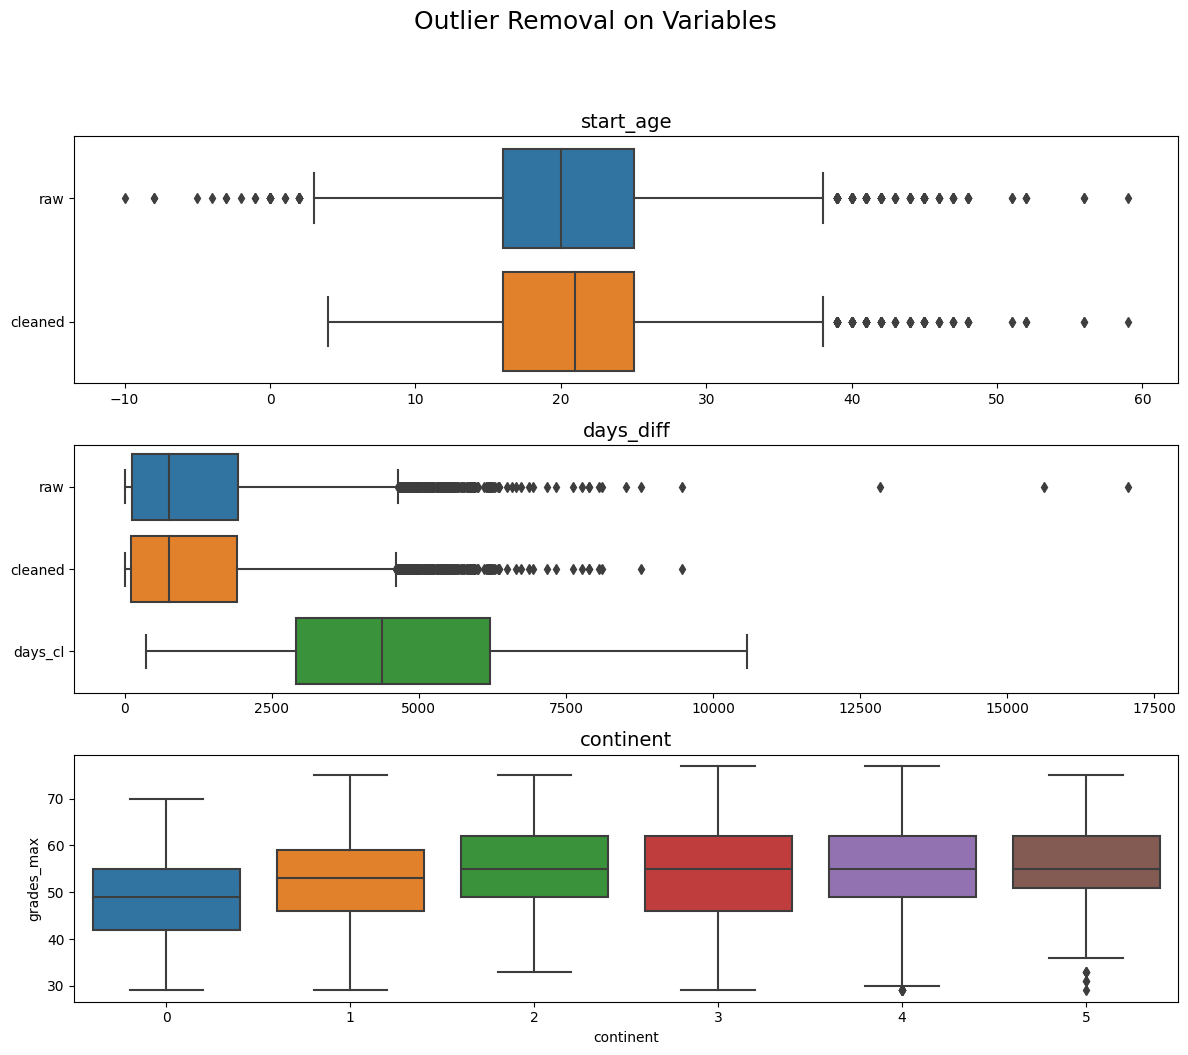

Values for continent: ['Africa', 'South America', 'Eurasia', 'Europe', 'North America', 'Oceania']


In [14]:
# create a grid of subplots for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

# Removing invalid start_age
outliers = outliers[outliers["start_age"]>3]
sb.boxplot(data = pd.DataFrame({"raw": dataset_cleaned["start_age"], "cleaned": outliers["start_age"]}), orient='h', ax = axes[0]);
axes[0].set_title("start_age", fontsize=14)

# Removing invalid days_diff
outliers = outliers[outliers["days_diff"]<(outliers["years_cl"]*365)]
sb.boxplot(data = pd.DataFrame({"raw": dataset_cleaned["days_diff"], "cleaned": outliers["days_diff"], "days_cl": dataset_cleaned["years_cl"]*365}), orient='h', ax = axes[1]);
axes[1].set_title("days_diff", fontsize=14)

# Removing unknown continents
outliers = outliers[outliers["continent"] != hi_map["Other"]]
sb.boxplot(x = 'continent', y = 'grades_max', data = outliers, ax = axes[2]);
axes[2].set_title("continent", fontsize=14)

# main title
fig.suptitle("Outlier Removal on Variables", fontsize=18, y=1.05)

# adjust the spacing between the subplots
fig.tight_layout()
plt.show()
print("Values for continent:", [x for x in hi_map if hi_map[x] in outliers["continent"].unique()])

dataset_cleaned1 = outliers[["continent", "sex", "age", "start_age", "height", "weight", "bmi", "days_diff", "grades_count", "grades_first", "grades_max"]]

## Correlation Heatmap<a class="anchor" id="corr-map"></a>
A final review of our changes to the dataset:
* 'erronous data' have been removed
* `country` has been mapped to numerical encoding ranked on mean score
* `height` and `weight` have been replaced with `bmi`
* `date_first` and `date_last` have been replaced with `days_diff`, and `years_cl` has been dropped
* 'outliers' for grades_count has been removed

With these changes, we can create our correlation heatmap for the variables that we will be using to build our linear regression model.

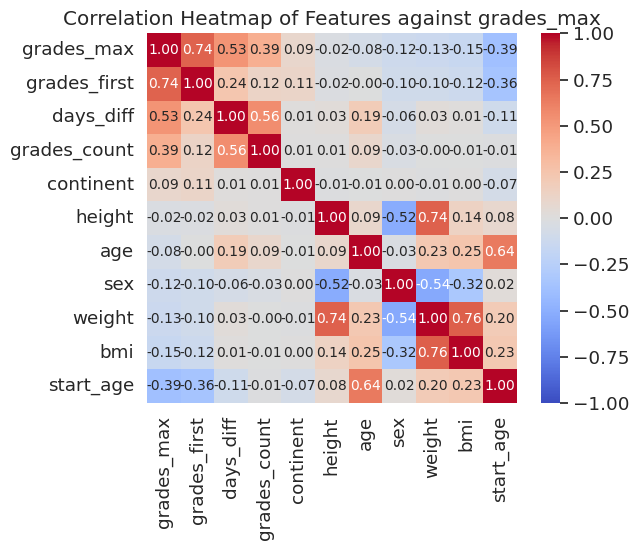

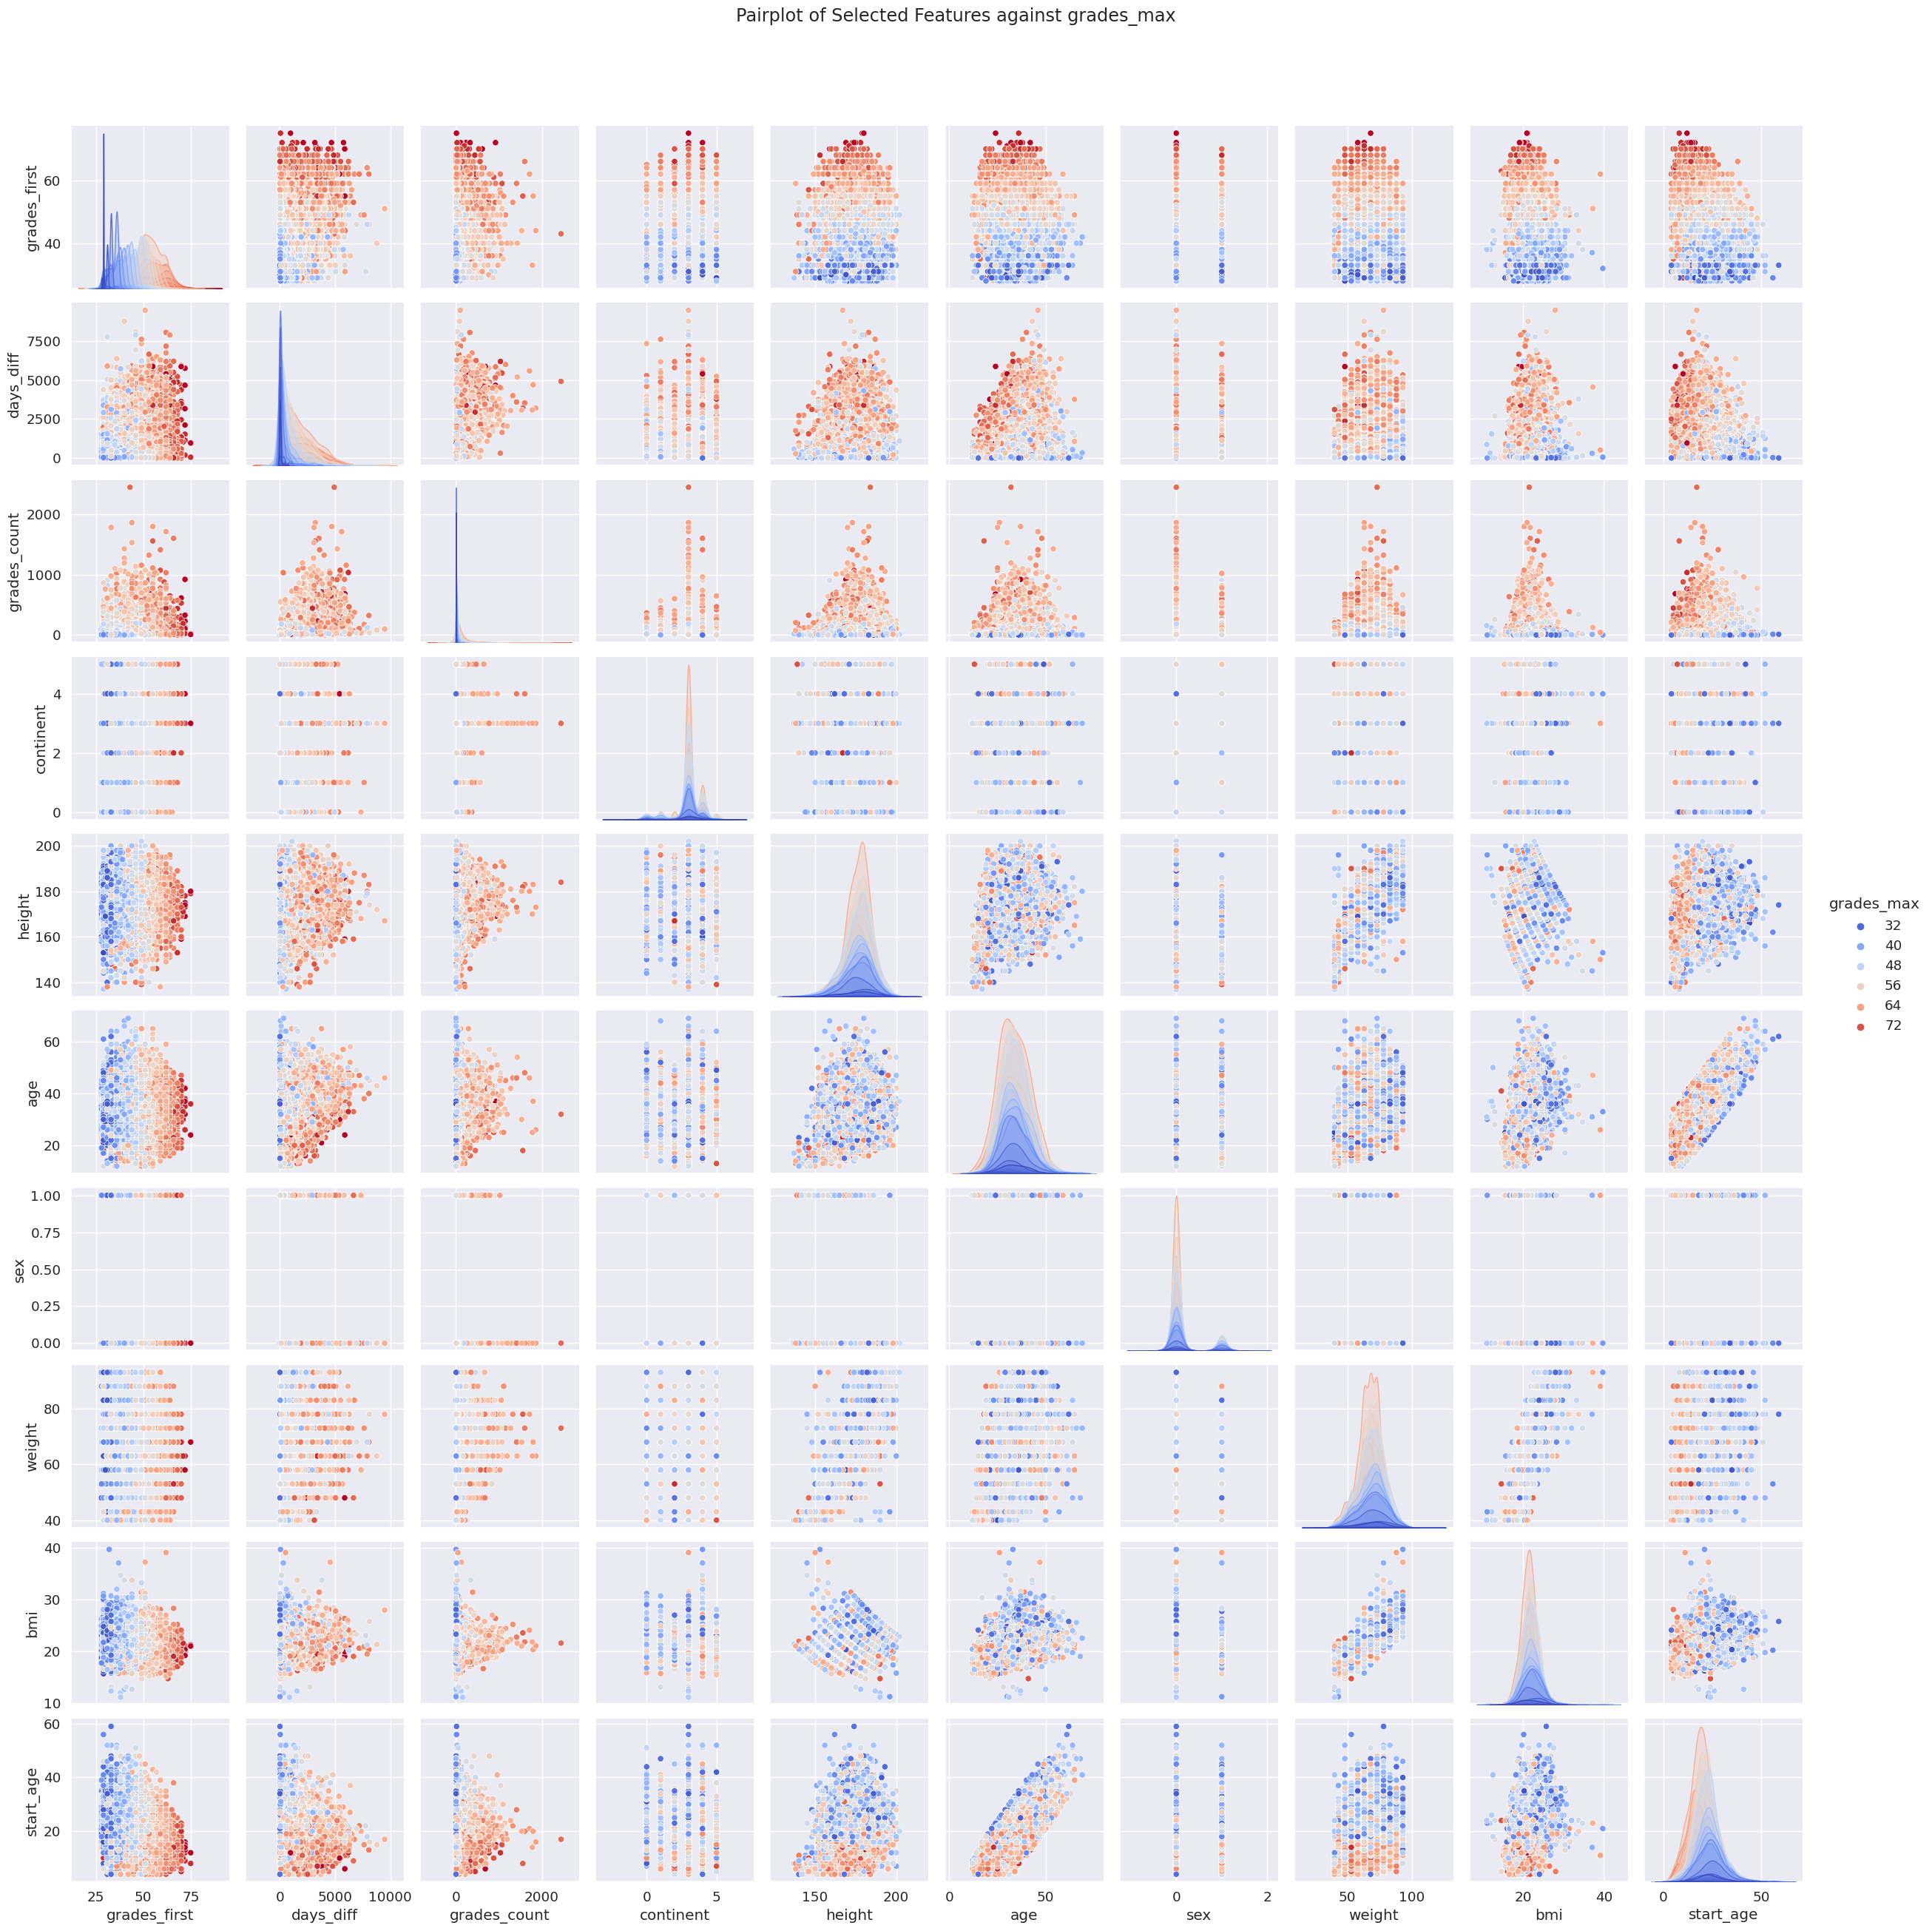

In [15]:
corr_matrix = dataset_cleaned1.corr(numeric_only=True)

k = 11 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'grades_max')['grades_max'].index
cm = np.corrcoef(dataset_cleaned1[cols].values.T)
sb.set(font_scale=1.2)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, vmin=-1, vmax=1, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap="coolwarm")
hm.set_title('Correlation Heatmap of Features against grades_max')
plt.show()

# Pairplot of Selected Features
sb.pairplot(dataset_cleaned1[cols.values], hue='grades_max', palette='coolwarm')
plt.suptitle("Pairplot of Selected Features against grades_max", y=1.05)
plt.show()


## Multi-variate Linear Regression Model<a class="anchor" id="linear-reg"></a>

We will be using a simple Linear Regression Model, where the predictor variables "country", "sex", "age", "bmi", "days_diff", "grades_count" and "grades_first" are are used to predict our response variable "grades_max".

From the Linear Regression Model, we have managed to obtain the following results:

---

Goodness of Fit of Model 	Train Dataset

Explained Variance (R^2) 	: 0.6773175814849197

Mean Squared Error (MSE) 	: 22.036718737196068

---

Goodness of Fit of Model 	Test Dataset

Explained Variance (R^2) 	: 0.6822313398032024

Mean Squared Error (MSE) 	: 22.034933755745303

---

We can also note that there is a slight curvature in both the graph of the training set and testing set, where there are more data points below the line of best fit.

This implies that the Linear Regression Model is underestimating the response variable, or the grades_max.

In [16]:
def linear_reg(dataset, plot=False, test_size=0.2, random_state=None):

    predictors = dataset.drop(columns=["grades_max"])
    response = pd.DataFrame(dataset["grades_max"])

    predictors_train, predictors_test, response_train, response_test = train_test_split(predictors, response, test_size = test_size, random_state = random_state)

    lr = LinearRegression().fit(predictors_train, response_train)

    response_train_pred = lr.predict(predictors_train)
    response_test_pred = lr.predict(predictors_test)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(21, 9))
        sb.scatterplot(x=response_train['grades_max'], y=response_train_pred.flatten(), color='blue', marker='o', ax=axes[0])
        sb.lineplot(x=response_train['grades_max'], y=response_train['grades_max'], color='orange', ax=axes[0], label='Line of Best Fit')
        axes[0].set_xlabel("True values of the Response Variable (Train)")
        axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
        axes[0].set_title("Training Set")
        axes[0].grid(True)

        sb.scatterplot(x=response_test['grades_max'], y=response_test_pred.flatten(), color='green', marker='o', ax=axes[1])
        sb.lineplot(x=response_test['grades_max'], y=response_test['grades_max'], color='orange', ax=axes[1], label='Line of Best Fit')
        axes[1].set_xlabel("True values of the Response Variable (Test)")
        axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
        axes[1].set_title("Testing Set")
        axes[1].grid(True)

        plt.show()

        # Check the Goodness of Fit (on Train Data)
        print("Goodness of Fit of Model \tTrain Dataset")
        print("Explained Variance (R^2) \t:", lr.score(predictors_train, response_train))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(response_train, response_train_pred))
        print()

        # Check the Goodness of Fit (on Test Data)
        print("Goodness of Fit of Model \tTest Dataset")
        print("Explained Variance (R^2) \t:", lr.score(predictors_test, response_test))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(response_test, response_test_pred))
        print()
    
    return lr.score(predictors_test, response_test
)

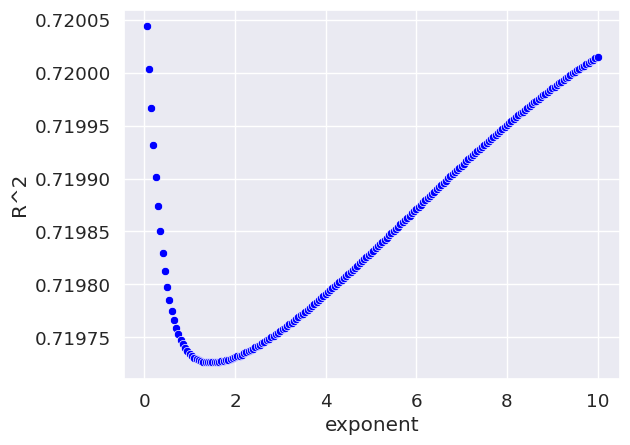

Optimal Exponent for continent: 0.05


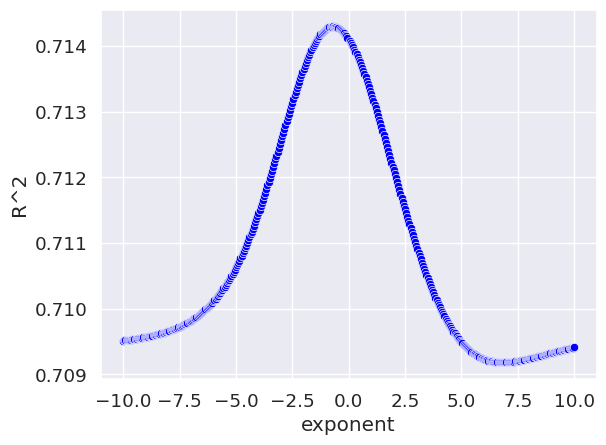

Optimal Exponent for age: -0.7


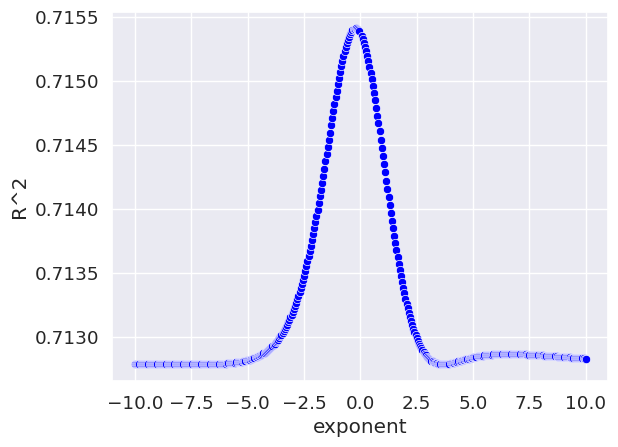

Optimal Exponent for start_age: -0.2


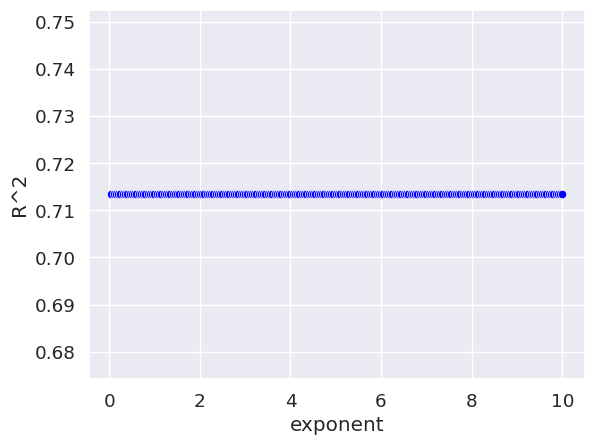

Optimal Exponent for sex: 0.05


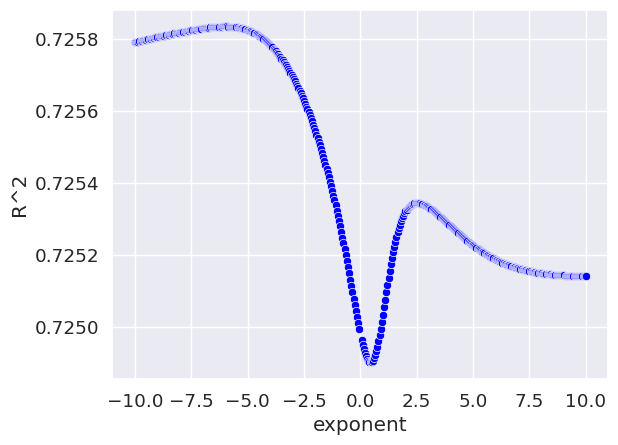

Optimal Exponent for bmi: -6.0


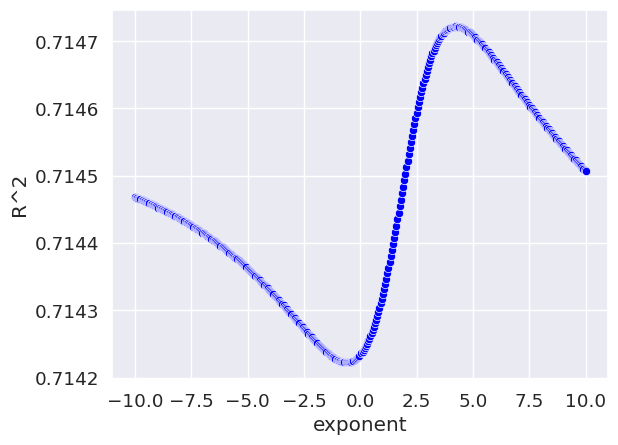

Optimal Exponent for height: 4.25


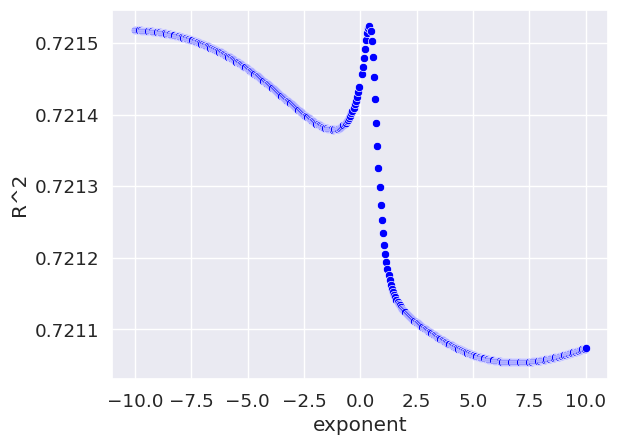

Optimal Exponent for weight: 0.4


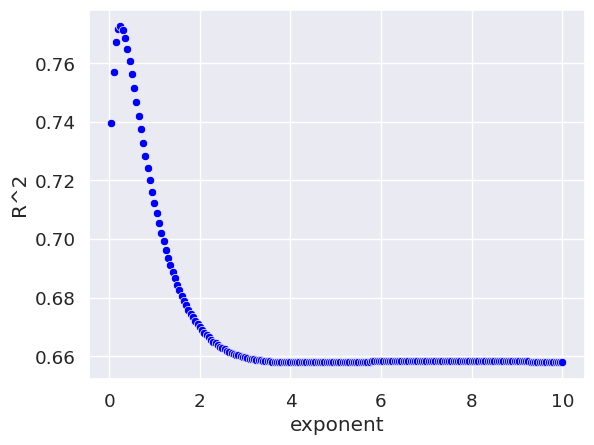

Optimal Exponent for days_diff: 0.25


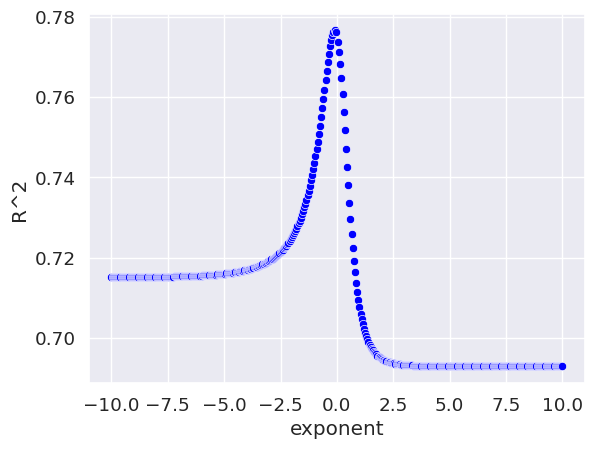

Optimal Exponent for grades_count: -0.1


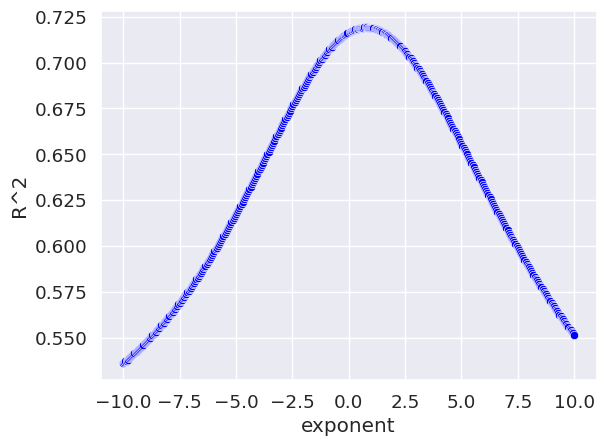

Optimal Exponent for grades_first: 0.75


In [17]:
import random
import warnings
warnings.filterwarnings("ignore")

dataset_norm = dataset_cleaned1.copy()

for col in dataset_norm.columns:
    if col=="grades_max": continue
    mean = dataset_norm[col].mean()
    std = dataset_norm[col].std()
    dataset_norm[col] = [(v-mean)/std for v in dataset_norm[col]]
    
def plot_var(col):
    res = pd.DataFrame({"exponent":[], "R^2":[]})
    dataset = dataset_cleaned1.copy()
    state = random.randint(1, 1<<32)
    for e in range(-200, 201):
        try:
            dataset[col] = pow(dataset_cleaned1[col], e/20)
            mean = dataset[col].mean()
            std = dataset[col].std()
            dataset[col] = [(v-mean)/std for v in dataset[col]]
            res.loc[len(res)] = {"exponent":e, "R^2":linear_reg(dataset, random_state=state)}
        except:
            pass
        
    return res

exponents = {}
# sb.scatterplot(x=grades_count['exponent'], y=grades_count["R^2"], color='blue', marker='o')
for col in ["continent", "age", "start_age", "sex", "bmi", "height", "weight", "days_diff", "grades_count", "grades_first"]:
    vals = plot_var(col)
    exponents[col] = vals.nlargest(1, "R^2")["exponent"].mean()/20
    sb.scatterplot(x=vals['exponent']/20, y=vals['R^2'], color='blue', marker='o')
    plt.show()
    print("Optimal Exponent for {}:".format(col), exponents[col])

{'continent': 1, 'age': -0.7, 'start_age': -0.2, 'sex': 1, 'bmi': -6.0, 'height': 4.25, 'weight': 0.4, 'days_diff': 0.25, 'grades_count': -0.1, 'grades_first': 0.75}


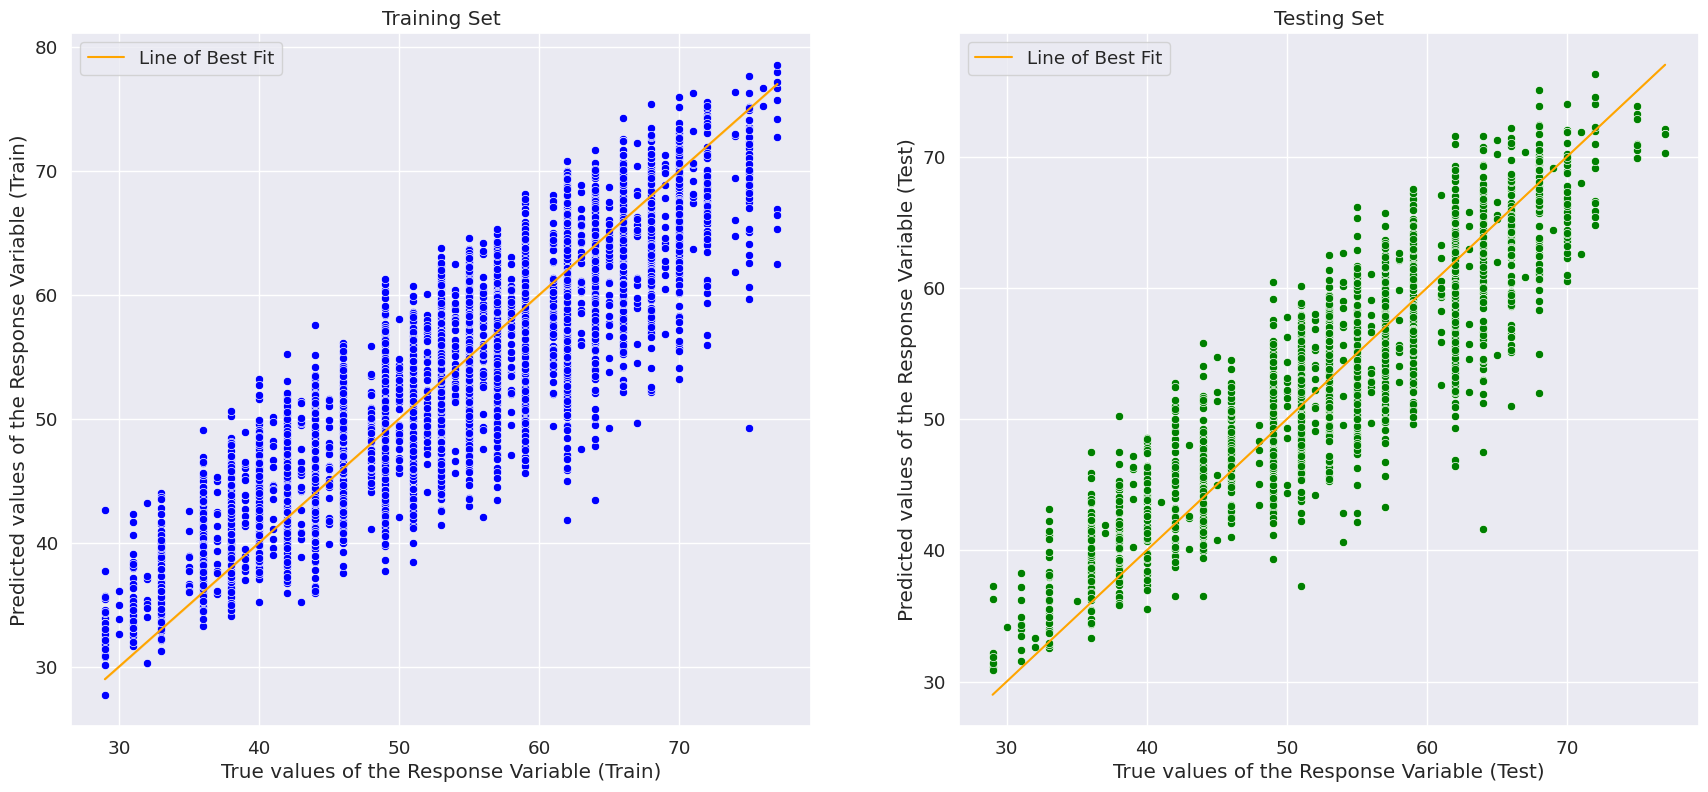

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7968100758949037
Mean Squared Error (MSE) 	: 19.227557843903735

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7869684697893304
Mean Squared Error (MSE) 	: 19.263173234905555



0.7869684697893304

In [27]:
dataset_final = dataset_cleaned1.copy()
exponents["continent"]=1
exponents["sex"]=1
print(exponents)
for col in exponents:
    if not exponents[col]: dataset_final = dataset_final.drop(columns=[col])
    dataset_final[col] = pow(dataset_final[col], exponents[col])
    mean = dataset_final[col].mean()
    std = dataset_final[col].std()
    dataset_final[col] = [(v-mean)/std for v in dataset_final[col]]

linear_reg(dataset_final, plot=True)

## Regression with K-Nearest Neighbours Algorithm<a class="anchor" id="knn"></a>

We also tried to use KNN algorithm which helps us to determine the grades_max of someone based on the neighbouring data values.

The results of the KNN algorithm is:

---

Explained Variance (R^2) for KNN 	: 0.48194217683437013

Mean Squared Error (MSE) for KNN 	: 35.9235231316726

---
  

Explained Variance (R^2) for SVM 	: 0.8217090198700229
Mean Squared Error (MSE) for SVM 	: 18.24077648684616


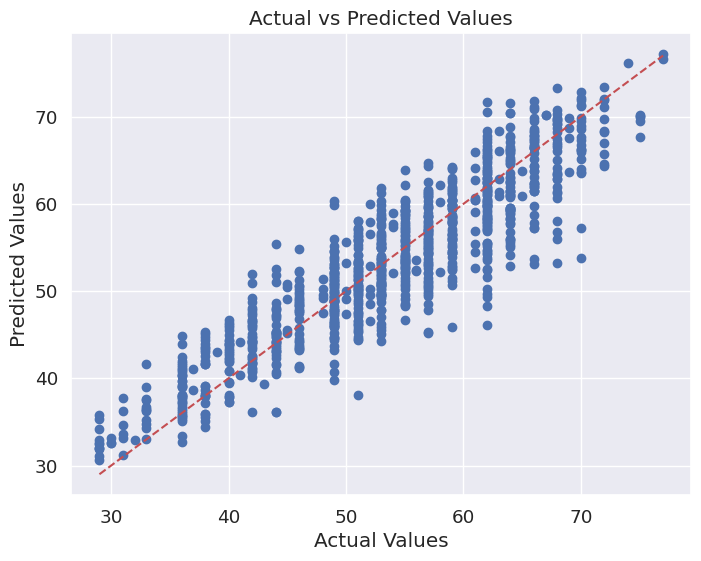

In [28]:
regr = svm.LinearSVR(max_iter=100000)
regr.fit(predictors_train, response_train["grades_max"])

y_pred = regr.predict(predictors_test)
r2 = r2_score(response_test, y_pred)
mse = mean_squared_error(response_test, y_pred)
print("Explained Variance (R^2) for SVM \t:", r2)
print("Mean Squared Error (MSE) for SVM \t:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(response_test, y_pred)
plt.plot([response_test.min(), response_test.max()], [response_test.min(), response_test.max()], linestyle='--', color='r')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Best value of n_neighbors: 20
Explained Variance (R^2) for KNN 	: 0.8324858173931922
Mean Squared Error (MSE) for KNN 	: 17.138212830957233


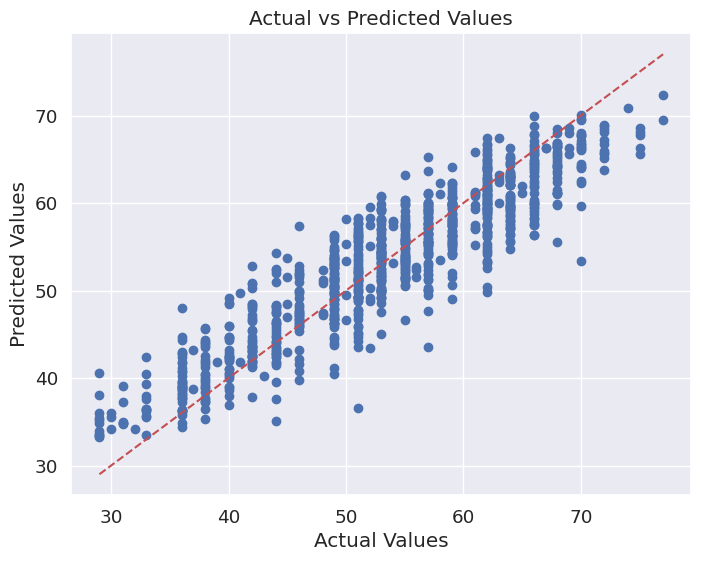

In [29]:
# Instantiate KNN regressor
knn_r = KNeighborsRegressor()

# Perform grid search to find optimal value of n_neighbors
gcv = GridSearchCV(knn_r, {'n_neighbors':[2,5,10,20,30,40,50,60,70,100]}).fit(predictors_train, response_train)
print("Best value of n_neighbors:", gcv.best_params_['n_neighbors'])

# Train KNN model with optimal n_neighbors value
knn = KNeighborsRegressor(gcv.best_params_['n_neighbors']).fit(predictors_train, response_train)

# Evaluate performance of KNN model
y_pred = knn.predict(predictors_test)
r2 = r2_score(response_test, y_pred)
mse = mean_squared_error(response_test, y_pred)
print("Explained Variance (R^2) for KNN \t:", r2)
print("Mean Squared Error (MSE) for KNN \t:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(response_test, y_pred)
plt.plot([response_test.min(), response_test.max()], [response_test.min(), response_test.max()], linestyle='--', color='r')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()